In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os
import cmath
import math

In [2]:
names = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
isel = dict()

tmask = hp.read_map("transition_mask.fits.gz")
#tmask_LFI = np.loadtxt("transition_mask_1024.dat")
W = dict()
W["X1"] = np.loadtxt("weights_T_smica_R3.00_Xfull.txt")
W["X2"] = np.loadtxt("weights_T_smica_R3.00_Xhigh.txt")

/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [3]:
isel = dict()
isel["X1"] = np.array([int(i) for i in "012345678"], dtype='int') # channel selection
isel["X2"] = np.array([int(i) for i in "345678"], dtype='int')

In [4]:
#unit conversion factors
unit_factor = [1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6*(1/58.0356), 1e6*(1/2.2681) ]
freq_band = np.asarray([30., 44., 70., 100., 143., 217., 353., 545., 857.])
nu0 = 57.0
bnu =  freq_band/(nu0)/np.tanh(0.5*freq_band/nu0) - 1
print(bnu)

[ 1.0459563   1.0983401   1.24525987  1.4884544   1.95320243  2.98000097
  5.21834777  8.56274973 14.0350966 ]


In [5]:
nside = 2048
elmax = 2048
alm_size = hp.sphtfunc.Alm.getsize(lmax = elmax, mmax = elmax)

#SMICA filter definition from smica_coadd code
#NOT USED IN THIS CODE so far.
def highpass_cos(lmax, l1=20, l2=40):
    """ From Planck compsep common tools
    """
    l = np.arange(lmax+1)
    b = 0.5 * (1.0 - np.cos(np.pi*(l-l1)/(l2-l1)))
    b = np.where(l < l1, 0.0, b)
    b = np.where(l > l2, 1.0, b)
    return b
tell = highpass_cos(lmax = elmax, l1=50, l2=150)


In [6]:
npix = 12*nside**2
freq_maps = np.ndarray(shape = (npix, 9))
i = 0
label = ['IQU', 'IQU', 'IQU', 'IQU', 'IQU', 'IQU', 'IQU', 'Int', 'Int']
for freq in names:
    print("Reading %s GHz Planck map" %(freq))
    if i < 3:
        freq_maps[:, i] = hp.pixelfunc.ud_grade(hp.read_map("HFI_SkyMap_%s-field-%s_2048_R3.00_full.fits" %(freq, label[i]), field = 0)*unit_factor[i], 2048)
    else:
        freq_maps[:, i] = hp.read_map("HFI_SkyMap_%s-field-%s_2048_R3.00_full.fits" %(freq, label[i]), field = 0)*unit_factor[i]
    freq_maps[:, i] = np.where(np.abs(freq_maps[:, i])>1e30, 0.0, freq_maps[:, i])
    i += 1


Reading 030 GHz Planck map


/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")


Reading 044 GHz Planck map
Reading 070 GHz Planck map
Reading 100 GHz Planck map


/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Reading 143 GHz Planck map
Reading 217 GHz Planck map
Reading 353 GHz Planck map
Reading 545 GHz Planck map
Reading 857 GHz Planck map


In [7]:
beff = np.ndarray(shape = (alm_size,), dtype = np.complex)
combalm = np.ndarray(shape = (alm_size,), dtype = np.complex)

In [8]:
alms = np.ndarray(shape = (alm_size, 9), dtype = np.complex)
alms_masked = np.ndarray(shape = (alm_size, 9), dtype = np.complex)


i = 0
for freq in names[0:9]:
    print("doing map2alm")
    alms[:, i] = hp.map2alm(maps = freq_maps[:, i], lmax=elmax, mmax = elmax, pol = False, iter = 0)
    i += 1

i = 0
for freq in names[0:9]:
    print("doing map2alm for masked maps")
    alms_masked[:, i] = hp.map2alm(maps = tmask*freq_maps[:, i], lmax=elmax, mmax = elmax, pol = False, iter = 0)
    i += 1



doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps
doing map2alm for masked maps


In [9]:
####################### Numerator of beff_alm ######################################

beff_alm_full = np.ndarray(shape = (alm_size,), dtype = np.complex)
beff_alm_full_masked = np.ndarray(shape = (alm_size,), dtype = np.complex)
#beff_alm_hfi = np.ndarray(shape = (alm_size,), dtype = np.complex)
beff_alm_hfi_masked = np.ndarray(shape = (alm_size,), dtype = np.complex)
beff_alm = np.ndarray(shape = (alm_size,), dtype = np.complex)

#alm_smica = hp.map2alm(smica_map*tmask, lmax=elmax, mmax = elmax, pol = False, iter = 0)
beff_alm_full.fill(0.0 + 0.0j)
beff_alm_full_masked.fill(0.0 + 0.0j)
#beff_alm_hfi.fill(0.0 + 0.0j)
beff_alm_hfi_masked.fill(0.0 + 0.0j)

for i in np.arange(0, 9, 1):
    beff_alm_full += bnu[i]*hp.almxfl(alms[:, i], W["X1"][i, :elmax + 1])

for i in np.arange(0, 9, 1):
    beff_alm_full_masked += bnu[i]*hp.almxfl(alms_masked[:, i], W["X1"][i, :elmax + 1])

for i in np.arange(0, 6, 1):
    beff_alm_hfi_masked += bnu[i+3]*hp.almxfl(alms_masked[:, i+3], W["X2"][i, :elmax + 1])

beff_alm = beff_alm_full + hp.almxfl((beff_alm_hfi_masked - beff_alm_full_masked), tell)
beff_alm = hp.almxfl(beff_alm, hp.pixwin(nside)[0:elmax+1])

#######################################################################################


In [10]:
########################## alm_smica #################################################

alm_full = np.ndarray(shape = (alm_size,), dtype = np.complex)
alm_full_masked = np.ndarray(shape = (alm_size,), dtype = np.complex)
#alm_hfi = np.ndarray(shape = (alm_size,), dtype = np.complex)
alm_hfi_masked = np.ndarray(shape = (alm_size,), dtype = np.complex)

alm_full.fill(0.0 + 0.0j)
alm_full_masked.fill(0.0 + 0.0j)
#alm_hfi.fill(0.0 + 0.0j)
alm_hfi_masked.fill(0.0 + 0.0j)


for i in np.arange(0, 9, 1):
    alm_full += hp.almxfl(alms[:, i], W["X1"][i, :elmax + 1])
    #beff_alm = test_bnu[i+3]*hp.almxfl(alm_smica, test_W[:elmax + 1])

for i in np.arange(0, 9, 1):
    alm_full_masked += hp.almxfl(alms_masked[:, i], W["X1"][i, :elmax + 1])

for i in np.arange(0, 6, 1):
    alm_hfi_masked += hp.almxfl(alms_masked[:, i+3], W["X2"][i, :elmax + 1])

alm_smica = alm_full + hp.almxfl((alm_hfi_masked - alm_full_masked), tell)
alm_smica  = hp.almxfl(alm_smica, hp.pixwin(nside)[0:elmax+1])

#######################################################################################


In [12]:
b_lm = np.ndarray(shape = (elmax+1, elmax+1), dtype = np.complex)
b_lm.fill(0.0)
beff.fill(0.0 + 0.0j)


def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]


for i in np.arange(2, alm_size, 1):
    smica_alm = np.asarray([[np.real(alm_smica[i]), np.imag(alm_smica[i])], [-1.0*np.imag(alm_smica[i]), np.real(alm_smica[i])]])
    #analytical inverse of smica alm matrix
    #smica_alm_inv = np.asarray([[np.real(alm_smica[i]), -1.0*np.imag(alm_smica[i])], [np.imag(alm_smica[i]), np.real(alm_smica[i])]])/(np.real(alm_smica[i])**2 + np.imag(alm_smica[i])**2)
    bwalm = np.asarray([np.real(beff_alm[i]), np.imag(beff_alm[i])])
    if is_invertible(smica_alm):
        bwalm = np.asarray([np.real(beff_alm[i]), np.imag(beff_alm[i])])
        b = np.dot(bwalm, np.linalg.inv(smica_alm) )
        # b = np.dot(bwalm, smica_alm_inv)
        l, m = hp.sphtfunc.Alm.getlm(lmax = elmax, i=i)
        beff[i] = np.complex(b[0], b[1])
        b_lm[l, m] = beff[i]
    else:
        print(hp.sphtfunc.Alm.getlm(lmax = elmax, i=i))
        continue

(1, 1)


In [13]:
beff_map = hp.alm2map(alms = beff, nside = nside, lmax=elmax, mmax=elmax, pixwin=False, fwhm=0.0, sigma=None, pol=False)

/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


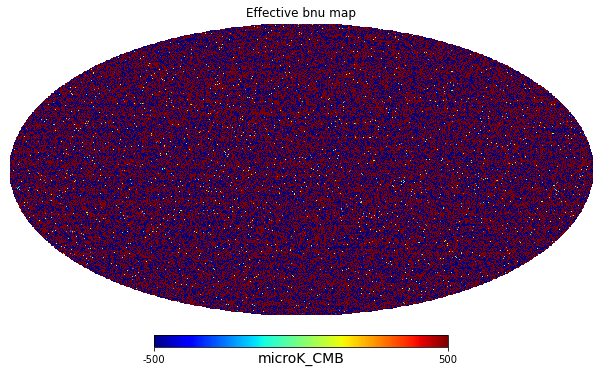

In [17]:
hp.mollview(map= beff_map,
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            title="Effective bnu map",
            min=-500, 
            max=500, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
plt.savefig('effective_bnu_map.pdf')

In [18]:
smica_map = hp.alm2map(alms = alm_smica, nside = nside, lmax=elmax, mmax=elmax, pixwin=False, fwhm=0.0, sigma=None, pol=False)

/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


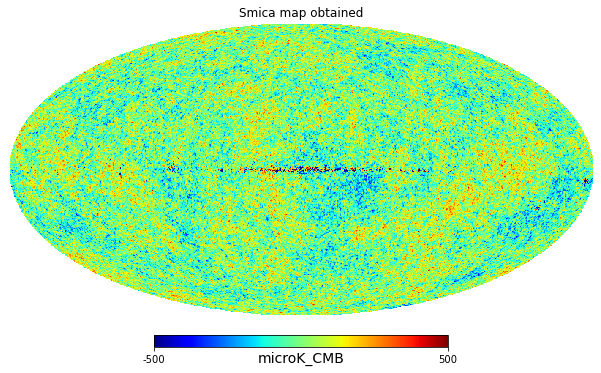

In [21]:
hp.mollview(map= smica_map,
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            title="Smica map obtained",
            min= -500, 
            max=500, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
plt.savefig('smica_map_obtained.pdf')

In [22]:
smica_map_r = hp.read_map("COM_CMB_IQU-smica_2048_R3.00_full.fits")*(1e6)

/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/Users/sayan/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: 

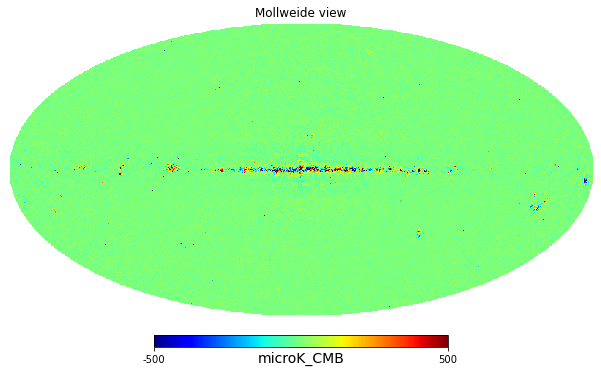

In [24]:
hp.mollview(map= (smica_map_r - smica_map),
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            min= -500, 
            max= 500, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
plt.savefig('map_difference.pdf')

In [ ]:
plt.hist((smica_map_r - smica_map), bins='auto')

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-105323.41196162, -105323.32114399, -105323.23032637, ...,
          25997.15106448,   25997.24188211,   25997.33269973]),
 <BarContainer object of 1445983 artists>)

In [11]:
blm_eff_real = np.real(b_lm)
blm_eff_img = np.imag(b_lm)

In [12]:
np.savetxt("b_lm_real.dat", blm_eff_real)
np.savetxt("b_lm_imag.dat", blm_eff_img)